# Application: Stellar Structure

During most of their lifetimes, stars are in hydrostatic and thermal equilibrium, and the structure of a star is well-described by the equations of stellar structure:

\begin{align*}
\frac{dP}{dr} &= -\rho \frac{Gm}{r^2} \\
\frac{dm}{dr} &= 4\pi r^2 \rho \\
\frac{dT}{dr} &= -\frac{3}{4ac} \frac{\kappa\rho}{T^3} \frac{F}{4\pi r^2} \\
\frac{dF}{dr} &= 4\pi r^2 \rho q
\end{align*}

with an equation of state, opacity, and energy generation rate of the form:

\begin{align*}
P &= \frac{\rho k T}{\mu_I m_u} + P_e + \frac{1}{3} a T^4 \\
\kappa &= \kappa_0 \rho^a T^b \\
q &= q_0 \rho^m T^n
\end{align*}

Here, $P$ is the pressure, $m$ is the mass enclosed inside a radius $r$, $T$ is the temperature, where we assume radiative equilibrium with $F$ describing an energy flux through a shell of radius $r$ and $\kappa$ the opacity of the material.  Finally $q$ is the energy generation rate from nuclear processes.  

This is a 2-point boundary value problem, with boundary conditions:

\begin{align*}
r(m=0) &= 0 \\
F(m=0) &= 0
\end{align*}

at the center and

\begin{align*}
P(m=M_\star) &= 0 \\
T(m=M_\star) &= T_\mathrm{eff} 
\end{align*}

at the surface.

We'll look at a simplified model here.

## Polytropes

If we consider just the first 2 equations, hydrostatic equilibrium and mass continuity, we can close the system of equations if we have an equation of state of the form $P = P(\rho)$.  This eliminates the need for the energy equations, simplifying the model and its solution.

We'll assume an equation of state of the form:

$$P = K \rho^{1+1/n}$$

where $n$ is called the _polytropic index_.



With a bit of algebra, we can combine these equations into a single second-order ODE for density:

$$\left ( \frac{n+1}{n} \right ) \frac{K}{4\pi G} \frac{1}{r^2} \frac{d}{dr} \left ( \frac{r^2}{\rho^{(n-1)/n}} \frac{d\rho}{dr} \right ) = -\rho$$

and then make it dimensionless, but expressing the density in terms of the central density, $\rho_c$:

$$\rho(r) = \rho_c \theta^n(r)$$

where we note that $0 \le \theta \le 1$, and a lenghtscale $\alpha$ such that $r = \alpha \xi$:

$$\alpha^2 = \frac{(n+1)P_c}{4\pi G\rho_c^2}$$

Giving

$$\frac{1}{\xi^2}\frac{d}{d\xi} \left ( \xi^2 \frac{d\theta}{d\xi} \right ) = -\theta^n$$

The boundary conditions are:

* $\theta(\xi=0) = 1$
* $d\theta / d\xi |_{\xi=0} = 0$ (symmetry about the origin + HSE)

but we don't know where the surface lies.  It is defined as $\xi_1$ as:

$$\xi_1 : \, \theta(\xi_1) = 0$$

This is called the [Lane-Emden equation](https://en.wikipedia.org/wiki/Lane%E2%80%93Emden_equation), and it has analytic solutions for $n = 0, 1, 5$.

Once you have the solution, you can get back physical quantities, including the mass of the star, the central pressure, average density, ...


## Solving the Lane-Emden equation

There are a variety of ways to solve this equation.  We are going to use the ideas from the boundary value example to integrate.

We'll use 4th order RK integration and we'll integrate both inward from the surface and outward from the center and meet at some point in the middle, $\xi_\mathrm{fit}$.

We rewrite our system by defining:

\begin{align*}
y &= \theta \\
z &= d\theta/d\xi = dy/d\xi
\end{align*}

then our system is:

\begin{align*}
\frac{dy}{d\xi} &= z \\
\frac{dz}{d\xi} &= -y^n - \frac{2}{\xi} z
\end{align*}

At $\xi = 0$, the righthand side of $dz/d\xi$ looks like it blows up, but in the limit $\xi \rightarrow 0$, it can be shown to be:

$$\frac{dz}{d\xi} \approx -\frac{1}{3}$$

We're going to integrate outward from the center and inward from the surface and meet in the middle.

At the center, our boundary conditions are:

* $y(0) = 1$
* $z(0) = 0$

and at the surface, $\xi_s$, they are:

* $y(\xi_s) = 0$
* $z(\xi_s) = \alpha$

Initially, we don't know either $\alpha$ or $\xi_s$.

Our algorithm will proceed as follows:

* Take an initial guess for $\alpha$ and $\xi_s$.  Pick $\xi_f = \xi/2$.

* Integrate from the center outward to the fit point, $\xi_f$, getting the solution: $y_\mathrm{out}(\xi_f)$, $z_\mathrm{out}(\xi_f)$.

* Integrate from the surface (starting at the guess $\xi_s$ inward to the fit point, getting the
solution $y_\mathrm{in}(\xi_f)$, $z_\mathrm{in}(\xi_f)$

* Constrain the solution to match at the fit point by finding the zero of:

  \begin{align*}
  Y(\alpha, \xi_s) &\equiv y_\mathrm{in}(\xi_f) - y_\mathrm{out}(\xi_f) = 0 \\
  Z(\alpha, \xi_s) &\equiv z_\mathrm{in}(\xi_f) - z_\mathrm{out}(\xi_f) = 0
  \end{align*}
  
  we will do this via the secant method.  This will yield a new guess for $\alpha$ and $\xi_s$.
  
* Iterate over this procedure until the $\alpha$ and $\xi_s$ converge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
def rhs(xi, H, n):
    
    y = H[0]
    z = H[1]

    f0 = z

    if xi == 0.0:
        f1 = 2.0/3.0 - y**n
    else:
        f1 = -2.0*z/xi - y**n

    return np.array([f0, f1])

In [3]:
def le_integrate(xi_start, xi_end, H0, n):

    sol = solve_ivp(rhs, (xi_start, xi_end), H0,
                    method="RK45", rotl=1.e-8, atol=1.e-8, args=(n,))

    xi = sol.t
    y = sol.y[0, :]
    z = sol.y[1, :]

    return xi, y, z

In [9]:
def solve_le(n):

    # initial guesses for the unknowns -- if we aren't careful with the
    # guess at the outer boundary, we can get 2 roots.  Here we know that
    # n = 1 has xi_s = pi

    if n > 2.0:
        xi_s = 8.0
    else:
        xi_s = np.pi

    alpha = -0.01

    # for numerical differentiation
    eps = 1.e-8

    # main iteration loop
    converged = False
    while not converged:

        # fitting point
        xi_fit = xi_s / 2.0

        # baseline integration

        # outward from the center
        xi_out, y_out, z_out = le_integrate(0.0, xi_fit, [1.0, 0.0], n)

        # inward from xi_s
        xi_in, y_in, z_in = le_integrate(xi_s, xi_fit, [0.0, alpha], n)

        # the two functions we want to zero
        Ybase = y_in[-1] - y_out[-1]
        Zbase = z_in[-1] - z_out[-1]

        # now do alpha + eps*alpha, xi_s
        # inward from xi_s
        H0 = np.array([0.0, alpha*(1.0+eps)])
        xi_in, y_in, z_in = le_integrate(xi_s, xi_fit, [0.0, alpha * (1.0 + eps)], n)

        Ya = y_in[-1] - y_out[-1]
        Za = z_in[-1] - z_out[-1]

        # our derivatives
        dYdalpha = (Ya - Ybase) / (alpha * eps)
        dZdalpha = (Za - Zbase) / (alpha * eps)

        # now do alpha, xi_s + eps*xi_s
        # inward from xi_s
        xi_in, y_in, z_in = le_integrate(xi_s  * (1.0 + eps), xi_fit, [0.0, alpha], n)

        Yxi = y_in[-1] - y_out[-1]
        Zxi = z_in[-1] - z_out[-1]

        # our derivatives
        dYdxi_s = (Yxi - Ybase) / (xi_s * eps)
        dZdxi_s = (Zxi - Zbase) / (xi_s * eps)

        # compute the correction for our two parameters
        dxi_s = - (Zbase - dZdalpha * Ybase / dYdalpha) / \
                    (dZdxi_s - dZdalpha * dYdxi_s / dYdalpha)

        dalpha = -(Ybase + dYdxi_s * dxi_s) / dYdalpha

        # limit the changes per iteration
        dalpha = min(abs(dalpha), 0.1 * abs(alpha)) * np.copysign(1.0, dalpha)
        dxi_s = min(abs(dxi_s), 0.1 * abs(xi_s)) * np.copysign(1.0, dxi_s)
                    
        print("corrections: ", dalpha, dxi_s)
        
        alpha += dalpha
        xi_s += dxi_s

        if abs(dalpha) < eps * abs(alpha) and abs(dxi_s) < eps * abs(xi_s):
            converged = True
            
    return xi_in, y_in, z_in, xi_out, y_out, z_out

In [10]:
n = 3
xi_in, y_in, z_in, xi_out, y_out, z_out = solve_le(n)

corrections:  -0.001 -0.8
corrections:  -0.0011 0.15718528189351433
corrections:  -0.0012100000000000001 -0.5727091335923138
corrections:  -0.001331 0.6784476148301201
corrections:  -0.0014641 -0.7462923763131322
corrections:  -0.0016105100000000001 0.6716631386818189
corrections:  -0.001771561 -0.6902697447871615
corrections:  -0.0019487171000000002 0.6698024780712846
corrections:  -0.0021435888100000003 -0.6389643168659439
corrections:  -0.0023579476910000003 0.6728862941918187
corrections:  -0.0025937424601 -0.6815262357771752
corrections:  -0.00285311670611 0.5575397839351558
corrections:  -0.0031384283767210003 -0.4548139323767661
corrections:  -0.0034522712143931003 0.1804967282749137
corrections:  -0.0037974983358324103 -0.09943245872683353
corrections:  -0.000508352267095884 0.004870849417551349
corrections:  -5.949161064537182e-06 -0.00034884714604119905
corrections:  1.0127323716161133e-08 6.347263556336021e-07
corrections:  -1.8739473510373166e-11 -1.100890203896195e-09


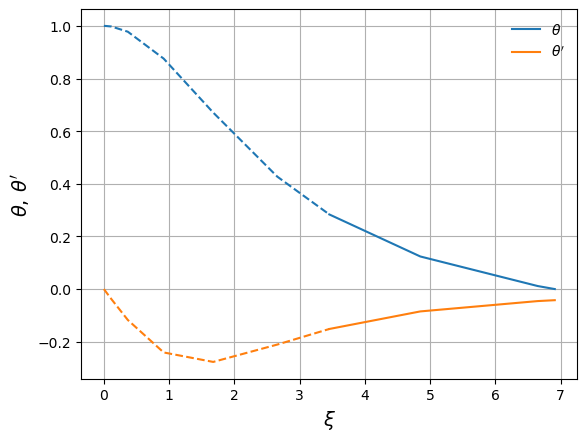

In [11]:
fig, ax = plt.subplots()

ax.plot(xi_in, y_in, color="C0", label=r"$\theta$")
ax.plot(xi_out, y_out, color="C0", ls="--")

ax.plot(xi_in, z_in, color="C1", label=r"$\theta'$")
ax.plot(xi_out, z_out, color="C1", ls="--")

ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel(r"$\theta,\, \theta'$", fontsize=14)

ax.legend(frameon=False, loc="best")
ax.grid()